# Setup and Data Loading 

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root='/Users/anamikasaroha/Energy7_Week1/week_4/point_machine_images', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Feature extraction with CNN 

In [2]:
def extract_features(model, dataloader):
    features = []
    model.eval()
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            features.append(outputs.cpu().numpy())
    return np.vstack(features)

# Load pretrained ResNet (remove last layer)
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Identity()  # Remove classification layer
model = model.to(device)

# Extract features
features = extract_features(model, dataloader)
print(f"Extracted features shape: {features.shape}")  # (n_samples, 512)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracted features shape: (1600, 512)


# Dimensionality reduction and Visualization 

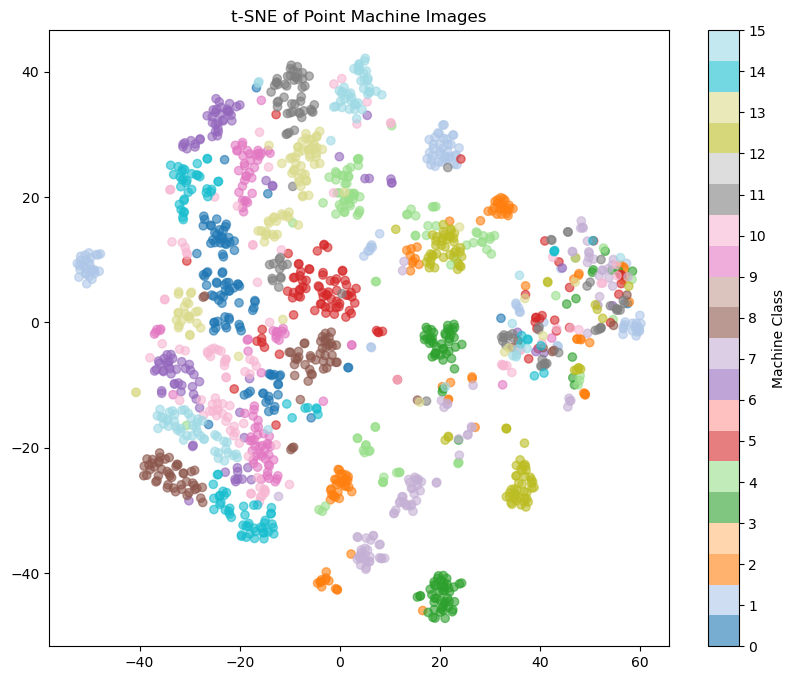

In [3]:
# t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=dataset.targets, cmap='tab20', alpha=0.6)
plt.colorbar(ticks=range(len(dataset.classes)), label='Machine Class')
plt.title("t-SNE of Point Machine Images")
plt.show()

# Unsupervised Clustering 

In [4]:
# K-Means Clustering
n_clusters = len(dataset.classes)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Evaluate clustering vs true labels
from sklearn.metrics import adjusted_rand_score
ari_score = adjusted_rand_score(dataset.targets, cluster_labels)
print(f"Clustering ARI Score: {ari_score:.2f} (1.0 = perfect match)")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clustering ARI Score: 0.16 (1.0 = perfect match)


# Supervised Classification 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features, dataset.targets, test_size=0.2, random_state=42
)

# Train classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# Evaluate
print(classification_report(y_test, clf.predict(X_test), target_names=dataset.classes))

              precision    recall  f1-score   support

     129_130       0.94      0.85      0.89        20
     159_160       0.84      1.00      0.91        21
   PT101_102       0.95      0.86      0.90        21
   PT119_120       0.88      0.81      0.85        27
  PT_101_102       0.92      0.58      0.71        19
PT_101___102       0.79      0.82      0.81        28
  PT_103_104       0.74      0.78      0.76        18
  PT_109_110       0.55      1.00      0.71        17
PT_111___112       0.88      0.83      0.86        18
  PT_119_120       0.74      0.82      0.78        17
PT_119___120       0.80      0.57      0.67        21
  PT_121_122       0.71      0.74      0.72        23
  PT_129_130       0.83      0.88      0.86        17
PT_135___136       1.00      0.79      0.88        19
PT_157___158       0.68      0.76      0.72        17
PT_189___190       0.93      0.82      0.87        17

    accuracy                           0.81       320
   macro avg       0.82   

# Anomaly detection 

In [6]:
from sklearn.ensemble import IsolationForest

# Train on normal samples (adjust based on your data)
normal_idx = [i for i, label in enumerate(dataset.targets) if label == 0]  # Assuming class 0 is normal
anomaly_detector = IsolationForest(contamination=0.05)
anomaly_detector.fit(features[normal_idx])

# Predict anomalies
anomaly_scores = anomaly_detector.decision_function(features)
anomalies = anomaly_scores < -0.1  # Threshold

print(f"Detected {anomalies.sum()} potential anomalies")

Detected 134 potential anomalies


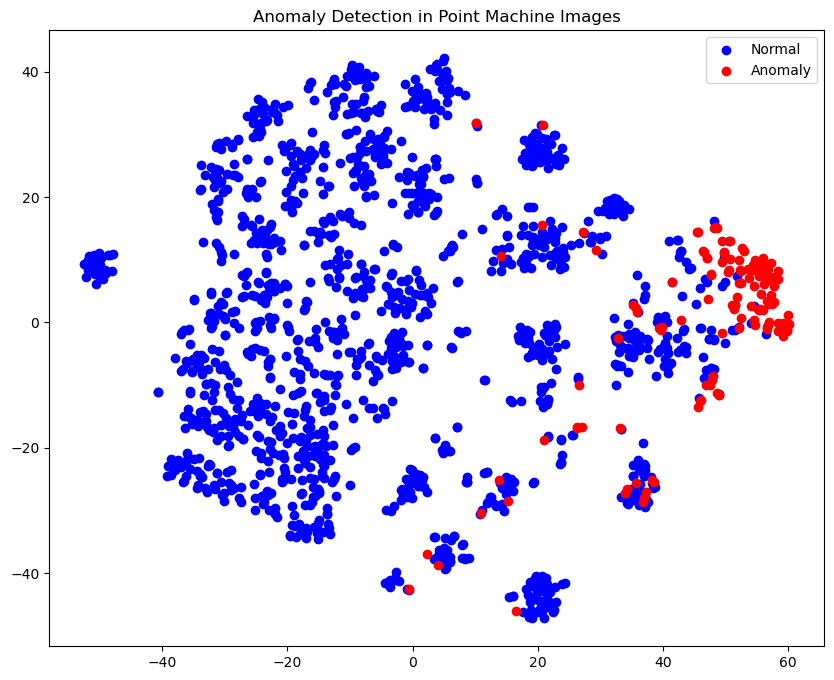

In [7]:
# Example of how to visualize anomalies
plt.figure(figsize=(10, 8))
plt.scatter(features_2d[~anomalies, 0], features_2d[~anomalies, 1], c='blue', label='Normal')
plt.scatter(features_2d[anomalies, 0], features_2d[anomalies, 1], c='red', label='Anomaly')
plt.title("Anomaly Detection in Point Machine Images")
plt.legend()
plt.show()


# Grad-Cam Visulization 

In [8]:
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

def visualize_gradcam(dataset, model, target_layers, num_samples=3):
    cam = GradCAM(model=model, target_layers=target_layers)
    
    for i in range(min(num_samples, len(dataset))):  # Prevent index overflow
        try:
            # Load image and predict
            img_tensor, true_label = dataset[i]
            input_tensor = img_tensor.unsqueeze(0).to(device)
            
            # Get prediction
            with torch.no_grad():
                output = model(input_tensor)
                pred_prob = torch.softmax(output, dim=1)[0]
                pred_class = torch.argmax(output).item()
                confidence = pred_prob[pred_class].item()
            
            # Verify prediction is valid
            if pred_class >= len(dataset.classes):
                print(f"Warning: Invalid prediction {pred_class} for sample {i}")
                continue
                
            # Generate heatmap
            grayscale_cam = cam(input_tensor=input_tensor, targets=None)
            grayscale_cam = grayscale_cam[0, :]
            
            # Prepare image
            rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy()
            rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
            
            # Plot
            plt.figure(figsize=(10, 4))
            plt.imshow(visualization)
            plt.title(
                f"True: {dataset.classes[true_label]} | "
                f"Pred: {dataset.classes[pred_class]} "
                f"(Confidence: {confidence:.2f})"
            )
            plt.axis('off')
            plt.colorbar(label='Activation Intensity')
            plt.show()
            
        except Exception as e:
            print(f"Skipping sample {i} due to error: {str(e)}")
            continue

# Verify dataset classes first
print("Available classes:", dataset.classes)
print("Class-to-index mapping:", dataset.class_to_idx)

# Then run visualization
target_layers = [model.layer4[-1]]  # For ResNet
visualize_gradcam(dataset, model, target_layers)


Available classes: ['129_130', '159_160', 'PT101_102', 'PT119_120', 'PT_101_102', 'PT_101___102', 'PT_103_104', 'PT_109_110', 'PT_111___112', 'PT_119_120', 'PT_119___120', 'PT_121_122', 'PT_129_130', 'PT_135___136', 'PT_157___158', 'PT_189___190']
Class-to-index mapping: {'129_130': 0, '159_160': 1, 'PT101_102': 2, 'PT119_120': 3, 'PT_101_102': 4, 'PT_101___102': 5, 'PT_103_104': 6, 'PT_109_110': 7, 'PT_111___112': 8, 'PT_119_120': 9, 'PT_119___120': 10, 'PT_121_122': 11, 'PT_129_130': 12, 'PT_135___136': 13, 'PT_157___158': 14, 'PT_189___190': 15}


In [9]:
import torch.nn as nn

# 1. Verify the input features to the final layer
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    features = model(dummy_input)
    print("Feature vector shape before fc:", features.shape)  # Should be (1, 512)

# 2. Replace Identity() with a proper classifier
num_classes = len(dataset.classes)  # 16 in your case
model.fc = nn.Sequential(
    nn.Linear(512, 256),  # Adjust based on features.shape[1]
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
).to(device)

# 3. Verify new architecture
print("\nModified Model Architecture:")
print(model)

Feature vector shape before fc: torch.Size([1, 512])

Modified Model Architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momen

In [10]:
print("Final layer input features:", model.fc[0].in_features)  # Must match features.shape[1]

Final layer input features: 512


In [11]:
test_output = model(dummy_input)
print("Test output shape:", test_output.shape)  # Should be (1, 16)

Test output shape: torch.Size([1, 16])


# training preparation 

In [12]:
# Freeze all layers except the new head
for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

# Set up optimizer only for trainable parameters
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Verify which layers are trainable
print("\nTrainable Parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)


Trainable Parameters:
fc.0.weight
fc.0.bias
fc.3.weight
fc.3.bias


In [13]:
import cv2
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image

def visualize_gradcam(model, dataset, target_layers, num_samples=5):
    """
    Working Grad-CAM visualization with current API
    Args:
        model: Your trained model
        dataset: ImageFolder dataset
        target_layers: List of target layers (e.g., [model.layer4[-1]])
        num_samples: Number of samples to visualize
    """
    # Initialize Grad-CAM (updated API)
    cam = GradCAM(model=model, target_layers=target_layers)
    
    for i in range(min(num_samples, len(dataset))):
        try:
            # Load and preprocess image
            img_tensor, true_label = dataset[i]
            input_tensor = img_tensor.unsqueeze(0).to(device)
            
            # Get prediction
            with torch.no_grad():
                output = model(input_tensor)
                pred_prob = torch.softmax(output, dim=1)[0]
                pred_class = torch.argmax(output).item()
                confidence = pred_prob[pred_class].item()
            
            # Generate heatmap (updated API)
            targets = [ClassifierOutputTarget(pred_class)]  # Focus on predicted class
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :]  # Remove batch dimension
            
            # Prepare RGB image
            rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy()
            rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
            
            # Create visualization
            visualization = show_cam_on_image(
                rgb_img,
                grayscale_cam,
                use_rgb=True,
                image_weight=0.5
            )
            
            # Plot results
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(rgb_img)
            plt.title(f"Original\nTrue: {dataset.classes[true_label]}")
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(visualization)
            plt.title(f"Grad-CAM\nPred: {dataset.classes[pred_class]} ({confidence:.2f})")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Skipping sample {i} due to: {str(e)}")
            continue

# Required import for new API
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Usage:
target_layers = [model.layer4[-1]]  # Last conv layer
visualize_gradcam(model, dataset, target_layers)
       

Skipping sample 0 due to: 'NoneType' object has no attribute 'shape'
Skipping sample 1 due to: 'NoneType' object has no attribute 'shape'
Skipping sample 2 due to: 'NoneType' object has no attribute 'shape'
Skipping sample 3 due to: 'NoneType' object has no attribute 'shape'
Skipping sample 4 due to: 'NoneType' object has no attribute 'shape'


In [14]:
# Check dataset returns valid images
test_img, _ = dataset[0]
print(f"Image shape: {test_img.shape}")  # Should be (3, H, W)

Image shape: torch.Size([3, 224, 224])


In [15]:
# Verify model produces valid outputs
with torch.no_grad():
    test_out = model(test_img.unsqueeze(0).to(device))
    print(f"Output shape: {test_out.shape}")  # Should be (1, n_classes)

Output shape: torch.Size([1, 16])


In [16]:
# Try different target layers
target_layers = [model.layer3[-1]]  # Mid-level features

In [17]:
# Test gradient flow
test_input = torch.randn(1, 3, 224, 224).to(device)
test_input.requires_grad_()
output = model(test_input)
output[0,0].backward()
print("Gradients exist:", test_input.grad is not None)  # Should be True

Gradients exist: True


In [18]:
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt

def visualize_gradcam(model, dataset, target_layers, num_samples=5):
    """
    Working Grad-CAM visualization with current API
    Args:
        model: Your trained model (must be in eval mode)
        dataset: ImageFolder dataset
        target_layers: List of target layers (e.g., [model.layer4[-1]])
        num_samples: Number of samples to visualize
    """
    # 1. Verify model is ready
    model.eval()
    if not isinstance(target_layers, list):
        target_layers = [target_layers]
    
    # 2. Initialize CAM (updated API)
    cam = GradCAM(
        model=model,
        target_layers=target_layers
    )
    
    for i in range(min(num_samples, len(dataset))):
        try:
            # 3. Load and prepare image
            img_tensor, true_label = dataset[i]
            input_tensor = img_tensor.unsqueeze(0).to(device)
            
            # 4. Get prediction
            with torch.no_grad():
                output = model(input_tensor)
                pred_class = output.argmax().item()
                confidence = torch.softmax(output, dim=1)[0][pred_class].item()
            
            # 5. Generate CAM with gradient tracking
            targets = [ClassifierOutputTarget(pred_class)]
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            
            if grayscale_cam is None:
                raise RuntimeError("CAM returned None - check target layers")
                
            grayscale_cam = grayscale_cam[0]  # Remove batch dim
            
            # 6. Prepare visualization
            rgb_img = img_tensor.permute(1, 2, 0).cpu().numpy()
            rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
            
            visualization = show_cam_on_image(
                rgb_img,
                grayscale_cam,
                use_rgb=True,
                image_weight=0.5
            )
            
            # 7. Display results
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            ax1.imshow(rgb_img)
            ax1.set_title(f"True: {dataset.classes[true_label]}")
            ax1.axis('off')
            
            ax2.imshow(visualization)
            ax2.set_title(f"Pred: {dataset.classes[pred_class]}\nConf: {confidence:.2f}")
            ax2.axis('off')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Skipping sample {i}: {str(e)}")
            continue

# Required imports
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Verify environment
print(f"Using pytorch-grad-cam version: {GradCAM.__module__.split('.')[-2]}")
print(f"Model device: {next(model.parameters()).device}")

# Run visualization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()  # Must be in eval mode!
target_layers = [model.layer4[-1]]  # Last conv layer
visualize_gradcam(model, dataset, target_layers)

Using pytorch-grad-cam version: pytorch_grad_cam
Model device: cpu
Skipping sample 0: 'NoneType' object has no attribute 'shape'
Skipping sample 1: 'NoneType' object has no attribute 'shape'
Skipping sample 2: 'NoneType' object has no attribute 'shape'
Skipping sample 3: 'NoneType' object has no attribute 'shape'
Skipping sample 4: 'NoneType' object has no attribute 'shape'


In [19]:
import torch
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

def visualize_with_torchcam(model, dataset, num_samples=5):
    """Reliable Grad-CAM using TorchCAM library"""
    # 1. Initialize CAM extractor
    cam_extractor = GradCAM(model, target_layer="layer4")
    
    for i in range(min(num_samples, len(dataset))):
        try:
            # 2. Load image
            img_tensor, true_label = dataset[i]
            input_tensor = img_tensor.unsqueeze(0)
            
            # 3. Get prediction and activation
            with torch.no_grad():
                output = model(input_tensor)
                pred_class = output.argmax().item()
                confidence = torch.softmax(output, dim=1)[0][pred_class].item()
            
            # 4. Generate CAM
            activation_map = cam_extractor(pred_class, output)
            
            if activation_map is None:
                raise RuntimeError("Failed to generate activation map")
                
            # 5. Process visualization
            img_pil = to_pil_image(img_tensor)
            overlay = overlay_mask(
                img_pil, 
                to_pil_image(activation_map[0].squeeze(0), mode='F'), 
                alpha=0.5
            )
            
            # 6. Display results
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            ax1.imshow(img_pil)
            ax1.set_title(f"True: {dataset.classes[true_label]}")
            ax1.axis('off')
            
            ax2.imshow(overlay)
            ax2.set_title(f"Pred: {dataset.classes[pred_class]}\nConf: {confidence:.2f}")
            ax2.axis('off')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Skipping sample {i}: {str(e)}")
            continue

# Usage
model.eval()
visualize_with_torchcam(model, dataset)

Skipping sample 0: cannot register a hook on a tensor that doesn't require gradient
Skipping sample 1: cannot register a hook on a tensor that doesn't require gradient
Skipping sample 2: cannot register a hook on a tensor that doesn't require gradient
Skipping sample 3: cannot register a hook on a tensor that doesn't require gradient
Skipping sample 4: cannot register a hook on a tensor that doesn't require gradient


In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        
        # Register hooks
        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook)
    
    def _forward_hook(self, module, input, output):
        self.activations = output
    
    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
    
    def get_cam(self, input_tensor, target_class=None):
        # Forward pass
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax().item()
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass for target class
        one_hot = torch.zeros_like(output)
        one_hot[0][target_class] = 1
        output.backward(gradient=one_hot)
        
        # Process gradients
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        
        # Weight activations by importance
        weighted_activations = torch.zeros_like(self.activations)
        for i in range(self.activations.size(1)):
            weighted_activations[:, i, :, :] = self.activations[:, i, :, :] * pooled_gradients[i]
        
        # Create heatmap
        heatmap = torch.mean(weighted_activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-10)
        
        return heatmap.cpu().detach().numpy()

def visualize_gradcam(model, dataset, num_samples=5):
    """Complete working Grad-CAM visualization"""
    model.eval()
    
    # 1. Find the last convolutional layer
    target_layer = None
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) and 'layer4' in name:
            target_layer = module
            break
    
    if target_layer is None:
        # Fallback to any Conv2d layer
        for module in model.modules():
            if isinstance(module, torch.nn.Conv2d):
                target_layer = module
                break
    
    if target_layer is None:
        raise ValueError("No convolutional layer found in model")
    
    print(f"Using target layer: {target_layer}")
    
    # 2. Initialize Grad-CAM
    gradcam = GradCAM(model, target_layer)
    
    for i in range(min(num_samples, len(dataset))):
        try:
            # 3. Prepare input
            img_tensor, true_label = dataset[i]
            input_tensor = img_tensor.unsqueeze(0)
            input_tensor = input_tensor.to(next(model.parameters()).device)
            input_tensor.requires_grad_(True)
            
            # 4. Get prediction
            with torch.no_grad():
                output = model(input_tensor)
                pred_class = output.argmax().item()
                confidence = F.softmax(output, dim=1)[0][pred_class].item()
            
            # 5. Generate heatmap
            heatmap = gradcam.get_cam(input_tensor, pred_class)
            
            # 6. Prepare visualization
            img = img_tensor.permute(1, 2, 0).cpu().numpy()
            img = (img - img.min()) / (img.max() - img.min())
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            ax1.imshow(img)
            ax1.set_title(f"True: {dataset.classes[true_label]}")
            ax1.axis('off')
            
            ax2.imshow(img)
            ax2.imshow(heatmap, alpha=0.5, cmap='jet')
            ax2.set_title(f"Pred: {dataset.classes[pred_class]}\nConf: {confidence:.2f}")
            ax2.axis('off')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Skipping sample {i}: {str(e)}")
            continue

# Usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# Run visualization
visualize_gradcam(model, dataset)

Using target layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Skipping sample 0: cannot register a hook on a tensor that doesn't require gradient
Skipping sample 1: cannot register a hook on a tensor that doesn't require gradient
Skipping sample 2: cannot register a hook on a tensor that doesn't require gradient
Skipping sample 3: cannot register a hook on a tensor that doesn't require gradient
Skipping sample 4: cannot register a hook on a tensor that doesn't require gradient
